# ECCO Salinity Budget

Pangeo verison of the Piecuch (2017) Budget Bible

In [5]:
import xarray as xr
import gcsfs
import numpy as np
from matplotlib import pyplot as plt

from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon

#from llc_plotter import LLCMapper

In [7]:
xr.set_options(display_style='text')

In [ ]:
from matplotlib import pyplot as plt
import cartopy as cart
import pyresample
class LLCMapper:
def __init__(self, ds, dx=0.25, dy=0.25):
# Extract LLC 2D coordinates
lons_1d = ds.XC.values.ravel()
lats_1d = ds.YC.values.ravel()
# Define original grid
self.orig_grid = pyresample.geometry.SwathDefinition(lons=lons_1d, lats=lats_
˓→1d)
# Longitudes latitudes to which we will we interpolate
lon_tmp = np.arange(-180, 180, dx) + dx/2
lat_tmp = np.arange(-90, 90, dy) + dy/2
# Define the lat lon points of the two parts.
self.new_grid_lon, self.new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
self.new_grid = pyresample.geometry.GridDefinition(lons=self.new_grid_lon,
lats=self.new_grid_lat)

def __call__(self, da, ax=None, projection=cart.crs.Robinson(), lon_0=-60, **plt_
˓→kwargs):
assert set(da.dims) == set(['face', 'j', 'i']), "da must have dimensions [
˓→'face', 'j', 'i']"
if ax is None:
fig, ax = plt.subplots(figsize=(12, 6))
field = pyresample.kd_tree.resample_nearest(self.orig_grid, da.values,
self.new_grid,
radius_of_influence=100000,
fill_value=None)
vmax = plt_kwargs.pop('vmax', field.max())
vmin = plt_kwargs.pop('vmin', field.min())
m = plt.axes(projection=projection)
x,y = self.new_grid_lon, self.new_grid_lat
# Find index where data is splitted for mapping
split_lon_idx = round(x.shape[1]/(360/(lon_0 if lon_0>0 else lon_0+360)))
p = m.pcolormesh(x[:,:split_lon_idx], y[:,:split_lon_idx], field[:,:split_lon_
˓→idx],
vmax=vmax, vmin=vmin, transform=cart.crs.PlateCarree(),
˓→zorder=1, **plt_kwargs)
p = m.pcolormesh(x[:,split_lon_idx:], y[:,split_lon_idx:], field[:,split_lon_
˓→idx:],
vmax=vmax, vmin=vmin, transform=cart.crs.PlateCarree(),
˓→zorder=2, **plt_kwargs)
m.add_feature(cart.feature.LAND, facecolor='0.5', zorder=3)
label = ''
if da.name is not None:
label = da.name
if 'units' in da.attrs:
label += ' [%s]' % da.attrs['units']
cb = plt.colorbar(p, shrink=0.4, label=label)
return m, ax

In [6]:
from dask.distributed import Client
client = Client()
client

/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:37213 Dashboard: /user/0000-0002-8176-9465/proxy/43867/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


In [8]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds  = cat["ECCOv4r3"].to_dask()
ds

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


<xarray.Dataset>
Dimensions:    (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
    Depth      (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    PHrefC     (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    PHrefF     (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG         (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YG         (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Z          (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Zl         (k_l) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Zp1        (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    Zu         (k_u) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    drC        (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    drF        (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    dxC        (face, j, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    dxG        (face, j_g, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    dyC        (face, j_g, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    dyG        (face, j, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    hFacC      (k, face, j, i) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    hFacS      (k, face, j_g, i) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    hFacW      (k, face, j, i_g) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    iter       (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    iter_snp   (time_snp) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k          (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_l        (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_p1       (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * k_u        (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    rA         (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAs        (face, j_g, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAw        (face, j, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAz        (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
Data variables:
    ADVr_SLT   (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVr_TH    (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVx_SLT   (time, k, face, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVx_TH    (time, k, face, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVy_SLT   (time, k, face, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVy_TH    (time, k, face, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    DFrE_SLT   (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    DFrE_TH    (time, k_l, face, j, i) float32 das

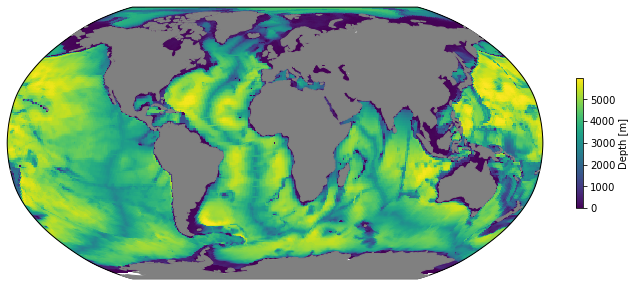

In [4]:
mapper = LLCMapper(ds.coords.to_dataset())
mapper(ds.Depth);

In [10]:
ds_ll = faces_dataset_to_latlon(ds)

In [11]:
# a trick to make things work a bit faster
mapper = ds_ll.coords.to_dataset()#.reset_coords()#.roll(i=50, i_g=50)
#ds = ds_ll_drop.reset_coords(drop=True).roll(i=50, i_g=50)

### Scale Factor

$$ s^\ast = 1 + \frac{\eta}{H} $$

In [13]:
s_star = 1 + ds.ETAN / ds.Depth
s_star

<xarray.DataArray (time: 288, face: 13, j: 90, i: 90)>
dask.array<add, shape=(288, 13, 90, 90), dtype=float32, chunksize=(1, 13, 90, 90), chunktype=numpy.ndarray>
Coordinates:
    Depth    (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
    rA       (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

In [14]:
import xgcm

# define the connectivity between faces
face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}

# create the grid object
grid = xgcm.Grid(ds, periodic=False, face_connections=face_connections)
grid

<xgcm.Grid>
Y Axis (not periodic):
  * center   j --> left
  * left     j_g --> center
T Axis (not periodic):
  * center   time --> inner
  * inner    time_snp --> center
X Axis (not periodic):
  * center   i --> left
  * left     i_g --> center
Z Axis (not periodic):
  * center   k --> left
  * left     k_l --> center
  * outer    k_p1 --> center
  * right    k_u --> center

### Volume Budget

We need some terms from the volume budget in order to do the salintiy budget.

In [15]:
gcs = gcsfs.GCSFileSystem()
ds_vb = xr.open_zarr(
    gcs.get_mapper('/pangeo-tmp/rabernat/ECCOv4r3/volume_budget.zarr'),
    consolidated=True)
ds_vb

<xarray.Dataset>
Dimensions:   (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
  * face      (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i         (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j         (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j_g       (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * k_l       (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_p1      (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49 50
  * k_u       (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * time_snp  (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
Data variables:
    G_conv_H  (time, k, face, j, i) float32 dask.array<chunksize=(48, 50, 1, 90, 90), meta=np.ndarray>
    G_conv_V  (time, k, face, j, i) float32 dask.array<chunksize=(48, 50, 1, 90, 90), meta=np.ndarray>
    G_forc    (time, face, j, i) float32 dask.array<chunksize=(288, 1, 90, 90), meta=np.ndarray>
    G_tot     (time, face, j, i) float32 dask.array<chunksize=(288, 1, 90, 90), meta=np.ndarray>

In [16]:
h = ds.hFacC
A = ds.rA
H = ds.Depth
v = h * A * ds.drF
rho0 = 1029

### Tendency term

Have to back out using centered difference of output snapshots.

In [17]:
delta_salt = grid.diff(ds.SALT_snp, 'T', boundary='fill', fill_value=np.nan)
delta_t = grid.diff(ds.time_snp, 'T', boundary='fill', fill_value=np.nan)

# convert to seconds
delta_t = delta_t.astype('f4') / 1e9

ds_budget = xr.Dataset(coords=ds.coords)
ds_budget['G_tot'] = delta_salt / delta_t
ds_budget

<xarray.Dataset>
Dimensions:   (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
    XC        (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC        (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
  * face      (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i         (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j         (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
    rA        (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Depth     (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Z         (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    drF       (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    PHrefC    (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Zp1       (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    drC       (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
  * k_p1      (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49 50
    PHrefF    (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    YG        (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g       (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    rAz       (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG        (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
  * k_l       (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    Zl        (k_l) float32 dask.array<chunksize=(50,), meta=np.ndarray>
  * k_u       (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    Zu        (k_u) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    dyG       (face, j, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAw       (face, j, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    dxC       (face, j, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    dyC       (face, j_g, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAs       (face, j_g, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    dxG       (face, j_g, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    hFacC     (k, face, j, i) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    hFacS     (k, face, j_g, i) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    hFacW     (k, face, j, i_g) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    iter      (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time_snp  (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
    iter_snp  (time_snp) int64 dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    G_tot     (time, k, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>

### Advection

Advection has two parts: the advective salt flux, and the tenduency due to volume convergence.

In [18]:
salt_flux_adv_x = ds.ADVx_SLT 
salt_flux_adv_y = ds.ADVy_SLT
salt_flux_adv_z = ds.ADVr_SLT

diff_h_flux = grid.diff_2d_vector({'X': salt_flux_adv_x, 'Y': salt_flux_adv_y},
                                             boundary='fill')
G_adv_H =  (- diff_h_flux['X'] - diff_h_flux['Y']) / v
# Z is positive down so doesn't need a negative sign
G_adv_V = grid.diff(salt_flux_adv_z, 'Z', boundary='fill') / v

ds_budget['G_adv'] = (G_adv_H + G_adv_V) / s_star

In [19]:
G_eta_conv = ds_vb.G_conv_H + ds_vb.G_conv_V

# rechunk to help alignment with SALT
ds_budget['G_adv_conv'] = -(ds.SALT * G_eta_conv.chunk(ds.SALT.chunks)) / s_star

### Diffusion

In [20]:
salt_flux_diff_x = ds.DFxE_SLT
salt_flux_diff_y = ds.DFyE_SLT
salt_flux_diff_z = ds.DFrE_SLT + ds.DFrI_SLT

diff_h_flux = grid.diff_2d_vector({'X': salt_flux_diff_x, 'Y': salt_flux_diff_y},
                                             boundary='fill')
G_diff_H =  (- diff_h_flux['X'] - diff_h_flux['Y']) / v
# Z is positive down so doesn't need a negative sign
G_diff_V = grid.diff(salt_flux_diff_z, 'Z', boundary='fill') / v

ds_budget['G_diff'] = (G_diff_H + G_diff_V) / s_star

### Surface Forcing

Has two parts: the surface flux and the salt plume.

In [21]:
# a helper function to expand a surface variable to a 3D variable
# with zeros below
def surf_to_3D(da):
    expand = da.assign_coords({'k': ds.k[0]}).expand_dims('k') 
    align, _ = xr.align(expand, ds.SALT, join='outer')
    fill = align.fillna(0.)
    rechunk = fill.transpose(*ds.SALT.dims).chunk(ds.SALT.chunks)
    return rechunk

In [22]:
G_forc = (surf_to_3D(ds.SFLUX) + ds.oceSPtnd) / (rho0 * h * ds.drF)
G_forc_conv = -ds.SALT * surf_to_3D(ds_vb.G_forc)
ds_budget['G_forc'] = (G_forc + G_forc_conv) / s_star

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  import sys


In [23]:
ds_budget

<xarray.Dataset>
Dimensions:     (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
    XC          (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC          (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
  * face        (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i           (i) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j           (j) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    rA          (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Depth       (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Z           (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    drF         (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
  * k           (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    PHrefC      (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Zp1         (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    drC         (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
  * k_p1        (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
    PHrefF      (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    YG          (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
  * i_g         (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g         (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
    rAz         (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG          (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
  * k_l         (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    Zl          (k_l) float32 dask.array<chunksize=(50,), meta=np.ndarray>
  * k_u         (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    Zu          (k_u) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    dyG         (face, j, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAw         (face, j, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    dxC         (face, j, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    dyC         (face, j_g, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAs         (face, j_g, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    dxG         (face, j_g, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    hFacC       (k, face, j, i) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    hFacS       (k, face, j_g, i) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    hFacW       (k, face, j, i_g) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    iter        (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time_snp    (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
    iter_snp    (time_snp) int64 dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    G_tot       (time, k, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    G_adv       (time, k, face, j, i) float32 dask.array<chunksize=(1, 49, 1, 89, 89), meta=np.ndarray>
    G_adv_conv  (time, k, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    G_diff      (time, k, face, j, i) float32 dask.array<chunksize=(1, 49, 1, 89, 89), meta=np.ndarray>
    G_forc      (time, k, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>

In [24]:
for vname in ds_budget.data_vars:
    ds_budget[vname].attrs['units'] = 'PSU s^-1'

## Visual G_tott Checks

We just load a single timestep worth of budget data.

In [27]:
ds_load = ds_budget.isel(time=100)
ds_load.nbytes / 1e6

173.966412

In [28]:
from dask.distributed import Client

client = Client("tcp://10.32.5.121:46353")
client

Client Scheduler: tcp://10.32.5.121:46353 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 20 Cores: 40 Memory: 230.00 GB


In [29]:
ds_load.load()

<xarray.Dataset>
Dimensions:     (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time_snp: 287)
Coordinates:
    XC          (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    YC          (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
  * face        (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i           (i) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j           (j) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    rA          (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Depth       (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Z           (k) float32 -5.0 -15.0 -25.0 ... -5039.25 -5461.25 -5906.25
    drF         (k) float32 10.0 10.0 10.0 10.0 10.0 ... 387.5 410.5 433.5 456.5
  * k           (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    PHrefC      (k) float32 49.05 147.15 245.25 ... 53574.863 57940.312
    Zp1         (k_p1) float32 0.0 -10.0 -20.0 -30.0 ... -5244.5 -5678.0 -6134.5
    drC         (k_p1) float32 5.0 10.0 10.0 10.0 ... 399.0 422.0 445.0 228.25
  * k_p1        (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
    PHrefF      (k_p1) float32 0.0 98.1 196.2 ... 51448.547 55701.18 60179.445
    YG          (face, j_g, i_g) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * i_g         (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g         (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
    rAz         (face, j_g, i_g) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    XG          (face, j_g, i_g) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * k_l         (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    Zl          (k_l) float32 0.0 -10.0 -20.0 -30.0 ... -4834.0 -5244.5 -5678.0
  * k_u         (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    Zu          (k_u) float32 -10.0 -20.0 -30.0 ... -5244.5 -5678.0 -6134.5
    dyG         (face, j, i_g) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rAw         (face, j, i_g) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dxC         (face, j, i_g) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dyC         (face, j_g, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rAs         (face, j_g, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dxG         (face, j_g, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hFacC       (k, face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hFacS       (k, face, j_g, i) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hFacW       (k, face, j, i_g) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    time        datetime64[ns] 2000-05-15
    iter        int64 73764
  * time_snp    (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
    iter_snp    (time_snp) int64 732 1428 2172 2892 ... 208164 208908 209628
Data variables:
    G_tot       (k, face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    G_adv       (k, face, j, i) float32 nan nan nan nan nan ... nan nan nan nan
    G_adv_conv  (k, face, j, i) float32 nan nan nan nan nan ... nan nan nan nan
    G_diff      (k, face, j, i) float32 nan nan nan nan nan ... nan nan nan nan
    G_forc      (k, face, j, i) float32 nan nan nan nan nan ... nan nan nan nan

In [30]:
vmax = 1e-6
vmax_tot = 2e-7
kwargs = dict(cmap='RdBu_r', vmax=vmax, vmin=-vmax)
kwargs_tot = dict(cmap='RdBu_r', vmax=vmax_tot, vmin=-vmax_tot)

(<cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7fb1b55b24a8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb1b69c9748>)

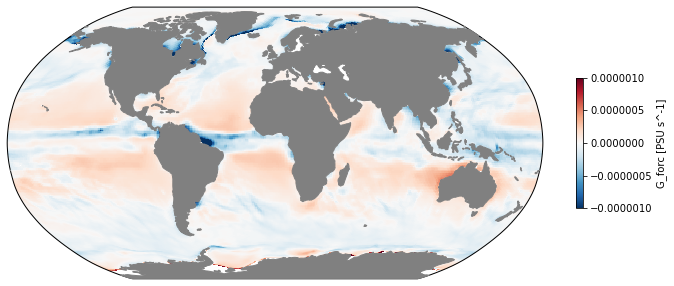

In [75]:
mapper(ds_load.G_forc[0], **kwargs)

(<cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7fb1b61e9f60>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb1b61d5f28>)

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:973: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


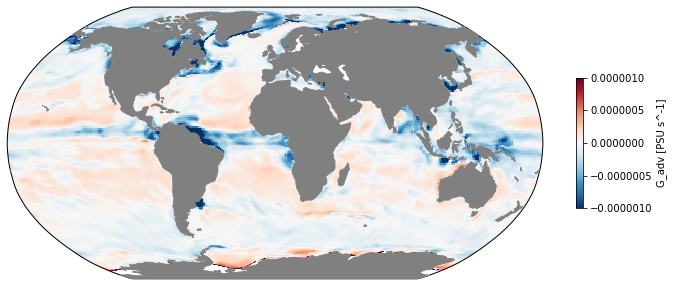

In [76]:
mapper(ds_load.G_adv[0], **kwargs)

(<cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7fb1b6fc5c18>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb1b6fcd400>)

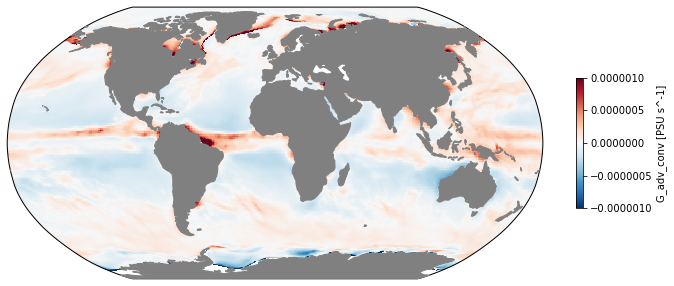

In [77]:
mapper(ds_load.G_adv_conv[0], **kwargs)

(<cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7fb1b6d0ffd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb1b59d14a8>)

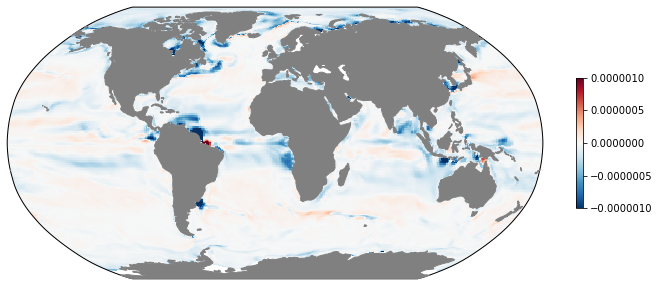

In [79]:
G_adv_tot = ds_load.G_adv + ds_load.G_adv_conv
mapper(G_adv_tot[0], **kwargs)

(<cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7fb1b54a0748>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb1b7426940>)

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:973: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


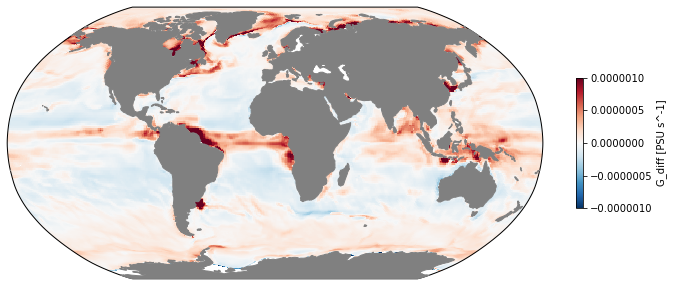

In [82]:
mapper(ds_load.G_diff[0], **kwargs)

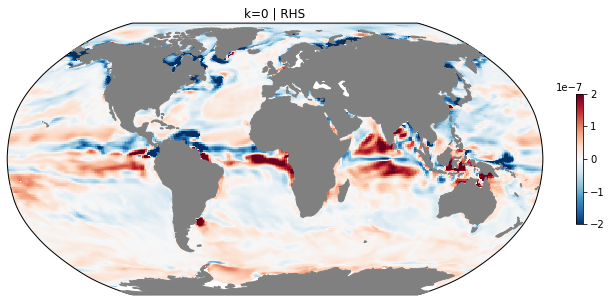

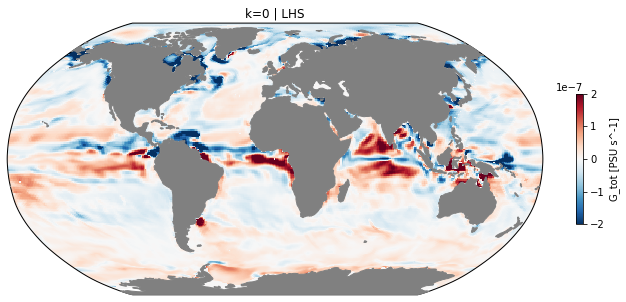

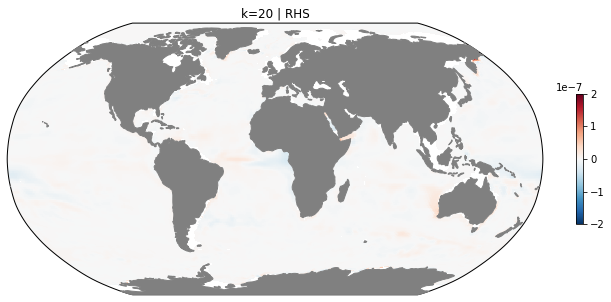

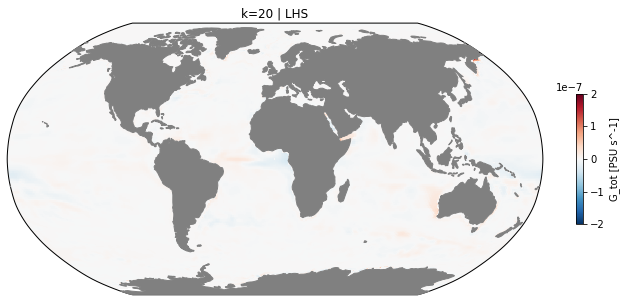

In [90]:
rhs = ds_load.G_forc + ds_load.G_adv + ds_load.G_adv_conv + ds_load.G_diff
for k in [0, 20]:
    mapper(rhs[k], **kwargs_tot)
    plt.title(f'k={k} | RHS')

    mapper(ds_load.G_tot[k], **kwargs_tot)
    plt.title(f'k={k} | LHS')

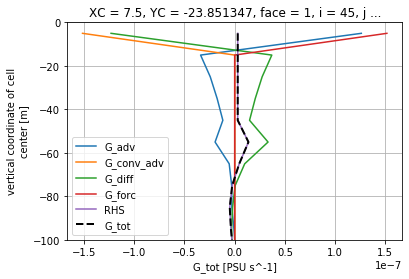

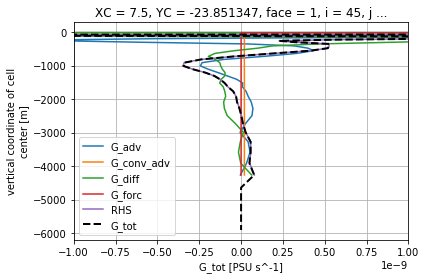

In [33]:
ds_point = ds_load.sel(face=1, i=45, j=45)
rhs_point = rhs.sel(face=1, i=45, j=45)

for xlim in [None, 1e-9]:
    plt.figure()
    ds_point.G_adv.plot(y='Z', label='G_adv')
    ds_point.G_adv_conv.plot(y='Z', label='G_conv_adv')
    ds_point.G_diff.plot(y='Z', label='G_diff')
    ds_point.G_forc.plot(y='Z', label='G_forc')
    rhs_point.plot(y='Z', label='RHS')   
    ds_point.G_tot.plot(y='Z', label='G_tot', color='k', ls='--', linewidth=2)   
    if xlim:
        plt.xlim([-xlim, xlim])
    else:
        plt.ylim([-100, 0])

    plt.grid()
    plt.legend()

### Save to Zarr

In [104]:
ds_budget_save = (ds_budget
                  .chunk({'i': -1, 'j': -1, 'k': -1,
                          'face': 1, 'time': '100MB'})
                  .reset_coords(drop=True))
ds_budget_save

<xarray.Dataset>
Dimensions:     (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
  * face        (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i           (i) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j           (j) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k           (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_p1        (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * i_g         (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g         (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k_l         (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_u         (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * time_snp    (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
Data variables:
    G_tot       (time, k, face, j, i) float32 dask.array<chunksize=(48, 50, 1, 90, 90), meta=np.ndarray>
    G_adv       (time, k, face, j, i) float32 dask.array<chunksize=(48, 50, 1, 90, 90), meta=np.ndarray>
    G_adv_conv  (time, k, face, j, i) float32 dask.array<chunksize=(48, 50, 1, 90, 90), meta=np.ndarray>
    G_diff      (time, k, face, j, i) float32 dask.array<chunksize=(48, 50, 1, 90, 90), meta=np.ndarray>
    G_forc      (time, k, face, j, i) float32 dask.array<chunksize=(48, 50, 1, 90, 90), meta=np.ndarray>

In [105]:
import json
with open('pangeo-181919-f141378dc975.json') as f:
    token = json.load(f)
    
import gcsfs
gcs = gcsfs.GCSFileSystem(token=token)
gcs

In [106]:
target_path = '/pangeo-tmp/rabernat/ECCOv4r3/salinity_budget.zarr'
store = gcs.get_mapper(target_path)
save_future = ds_budget_save.to_zarr(store, mode='w', compute=False)
save_future

Delayed('_finalize_store-4d90d699-3bbe-4c07-a6b8-d03c97b410e6')

In [108]:
len(save_future.dask)

710773

In [ ]:
save_future.compute(retires=5)